# 03- Exploratory Data Analysis on Filtered Previous Violations Data

**Goal**: The goal of this notebook is to explore the results from the fitting of the filtered previous violation regressor.

Relationships of interests
- tau vs : time to train, trained hit rate, trained violation rate, prev viol weight, delta ll
- prev viol weights vs ttt, trained hit, trained viol

Related notebooks:
* 2024_02_16_EXP_tau_sweep_prev_violation.ipynb
* 2024_02_17_EXP_compare_filtered_prev_violation.ipynb


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from multiglm.data.dataset_loader import DatasetLoader
from multiglm.experiments.experiment import load_experiment
from multiglm.utils.violation_iti import *

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

## Load In

In [3]:
trained_df = DatasetLoader(data_type="new_trained").load_data()

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


## Violation ITI


In [4]:
iti = ViolationITI()

iti_df = iti.compute_and_add_viol_iti_column(trained_df)

iti_df.head()

,animal_id,session_date,session_file_counter,rig_id,training_stage,s_a,s_b,hit,violation,trial_not_started,...,r_water_vol,antibias_beta,antibias_right_prob,using_psychometric_pairs,choice,session,session_relative_to_old,n_prev_trial_not_started,trial,violation_iti
0,W051,2014-07-17,327,19,4,60.0,68.0,NaN,1,False,...,18.000000,3,0.5,NaN,2,326,326.0,0.0,1,NaN
1,W051,2014-07-17,327,19,4,60.0,68.0,NaN,1,False,...,18.000001,3,0.5,NaN,2,326,326.0,0.0,2,0.0
2,W051,2014-07-17,327,19,4,76.0,68.0,NaN,1,False,...,18.000004,3,0.5,NaN,2,326,326.0,0.0,3,0.0
3,W051,2014-07-17,327,19,4,68.0,76.0,1.0,0,False,...,18.000014,3,0.5,NaN,0,326,326.0,0.0,4,NaN
4,W051,2014-07-17,327,19,4,84.0,76.0,1.0,0,False,...,18.000033,3,0.5,NaN,1,326,326.0,0.0,5,NaN


In [5]:
violation_iti_summary_stats = (
    iti_df.groupby(["animal_id", "session"])
    .agg(
        viol_iti_mean=("violation_iti", "mean"),
        viol_iti_median=("violation_iti", "median"),
    )
    .reset_index()
    .groupby("animal_id")
    .agg({"viol_iti_mean": "mean", "viol_iti_median": "median"})
    .reset_index()
)

violation_iti_summary_stats.head()

,animal_id,viol_iti_mean,viol_iti_median
0,W051,6.750916,4.0
1,W060,7.114417,4.0
2,W065,3.266451,1.0
3,W066,3.242801,2.0
4,W068,5.636738,3.0


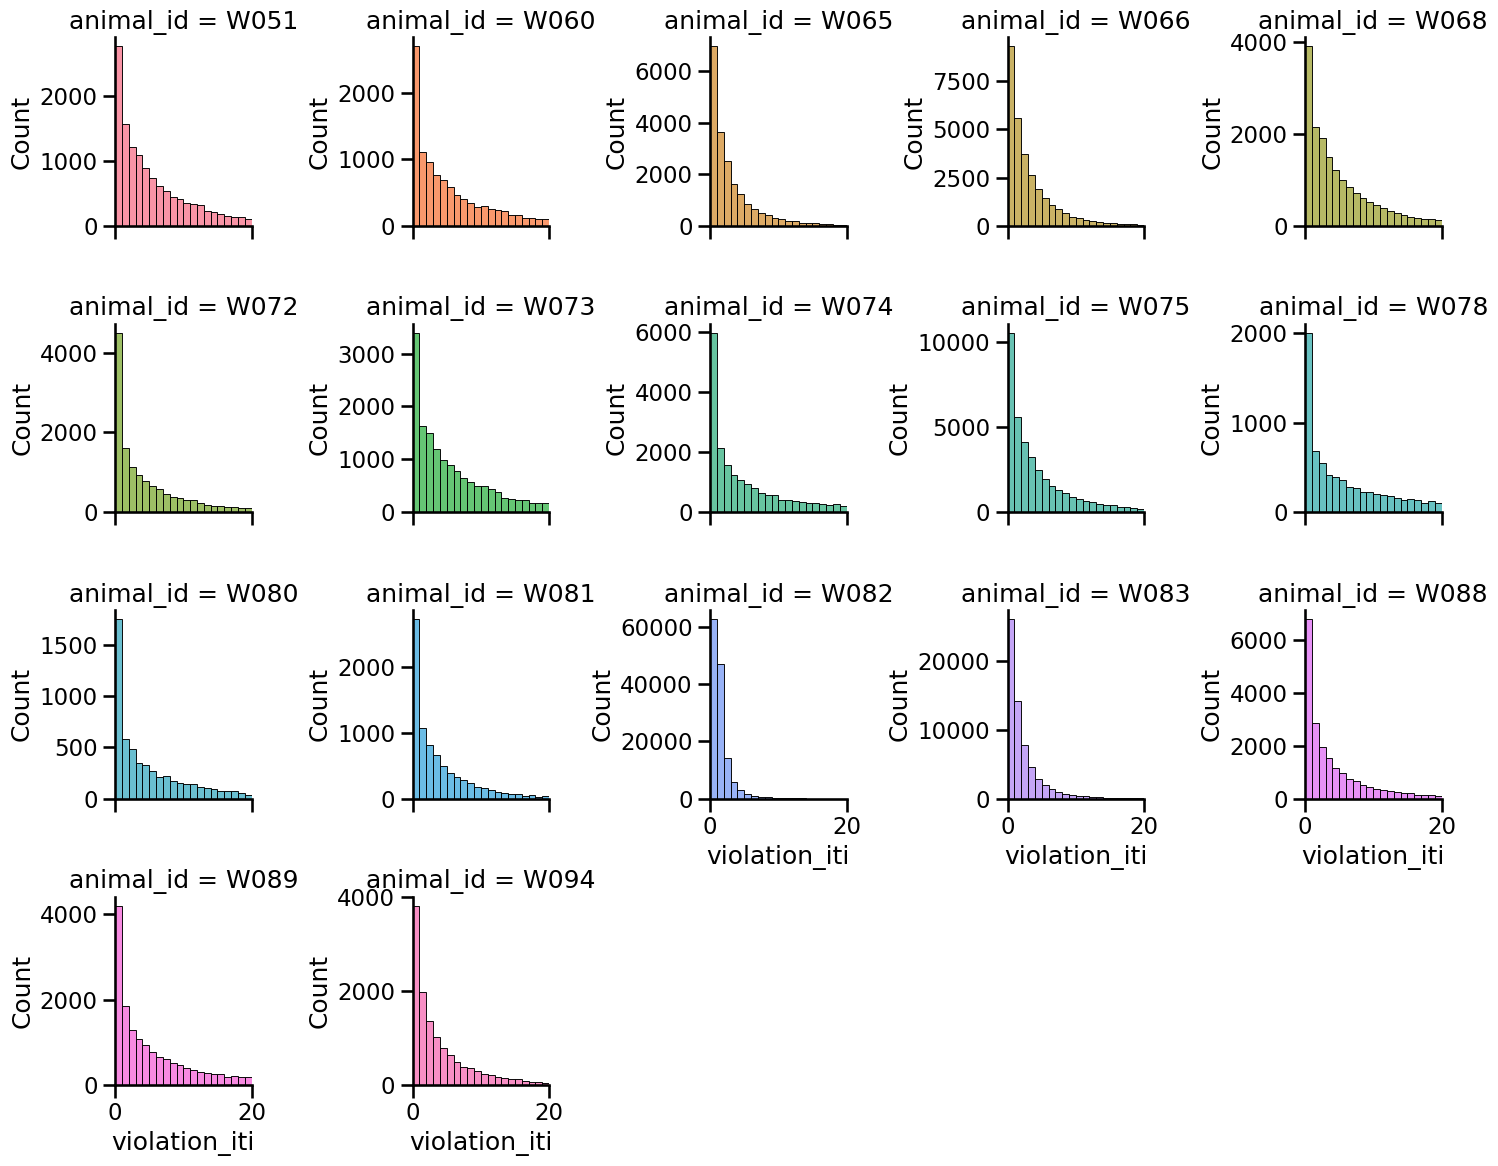

In [6]:
g = sns.FacetGrid(
    data=iti_df,
    col="animal_id",
    hue="animal_id",
    col_wrap=5,
    xlim=(0, 20),
    sharey=False,
)
g.map(sns.histplot, "violation_iti", binwidth=1)

In [7]:
violation_iti_summary_stats

,animal_id,viol_iti_mean,viol_iti_median
0,W051,6.750916,4.0
1,W060,7.114417,4.0
2,W065,3.266451,1.0
3,W066,3.242801,2.0
4,W068,5.636738,3.0
5,W072,5.762710,2.5
6,W073,7.241704,4.0
7,W074,11.745782,4.0
8,W075,6.199512,3.0
9,W078,9.485322,5.0


Let's add in the mean inter violation interval for each animal

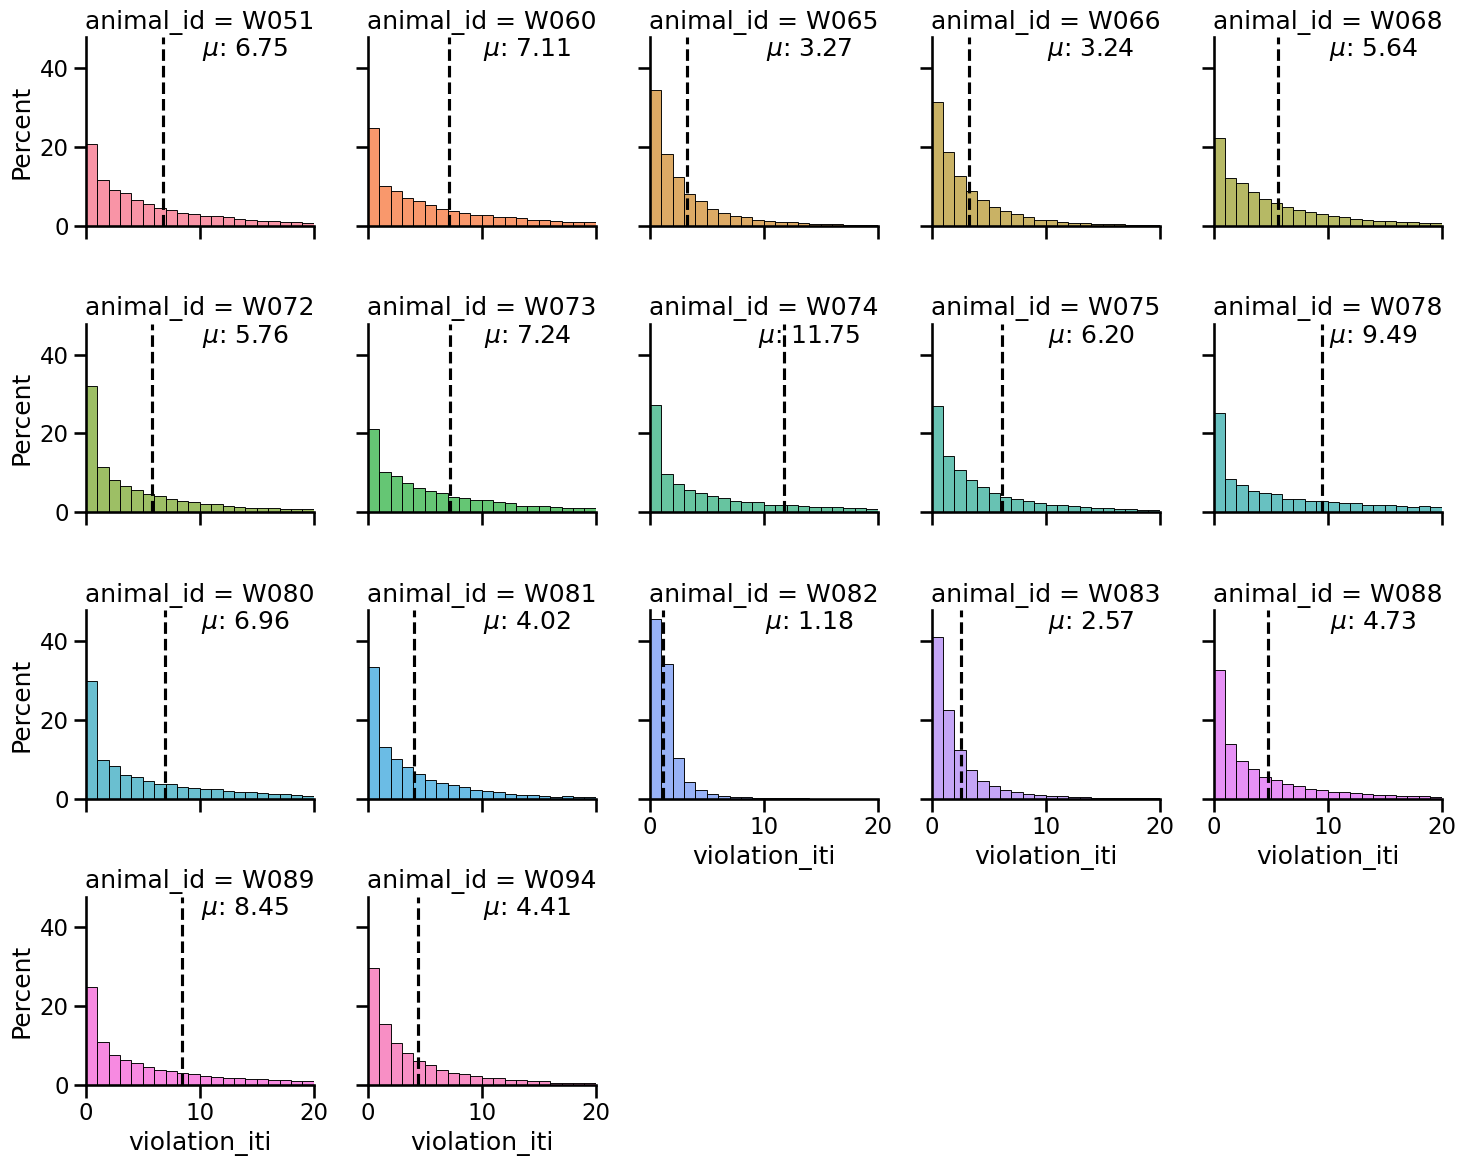

In [8]:
g = sns.FacetGrid(
    data=iti_df,
    col="animal_id",
    hue="animal_id",
    col_wrap=5,
    xlim=(0, 20),
    sharey=True,
)
g.map(sns.histplot, "violation_iti", stat="percent", binwidth=1)

for ax, animal_id in zip(g.axes.flat, g.data["animal_id"].unique()):
    # Use the animal_id to get the corresponding mean ITI value
    mean_iti = violation_iti_summary_stats.loc[
        violation_iti_summary_stats["animal_id"] == animal_id, "viol_iti_mean"
    ].values[0]

    # Annotate the plot with a vertical line for mean ITI
    ax.axvline(mean_iti, color="black", linestyle="--")
    ax.annotate(
        f"$\mu$: {mean_iti:.2f}",
        xy=(0.7, 0.9),
        xycoords="axes fraction",
        ha="center",
    )

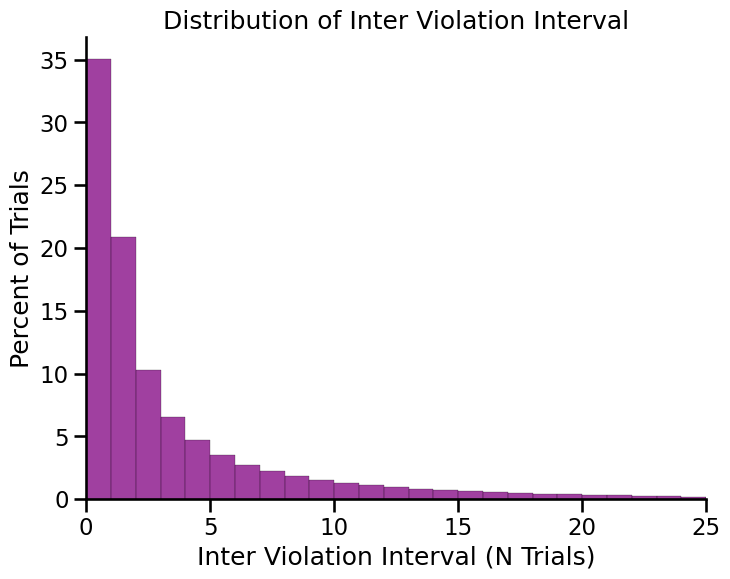

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=iti_df,
    x="violation_iti",
    stat="percent",
    color="purple",
    ax=ax,
    binwidth=1,
)

ax.set(
    xlim=(0, 25),
    xlabel="Inter Violation Interval (N Trials)",
    ylabel="Percent of Trials",
    title="Distribution of Inter Violation Interval",
)


sns.despine()

In [10]:
session_animal_avg_viol_iti = (
    iti_df.groupby(["animal_id", "session"])
    .violation_iti.mean()
    .reset_index()
    .groupby("animal_id")
    .violation_iti.mean()
    .reset_index()
    .violation_iti.mean()
)

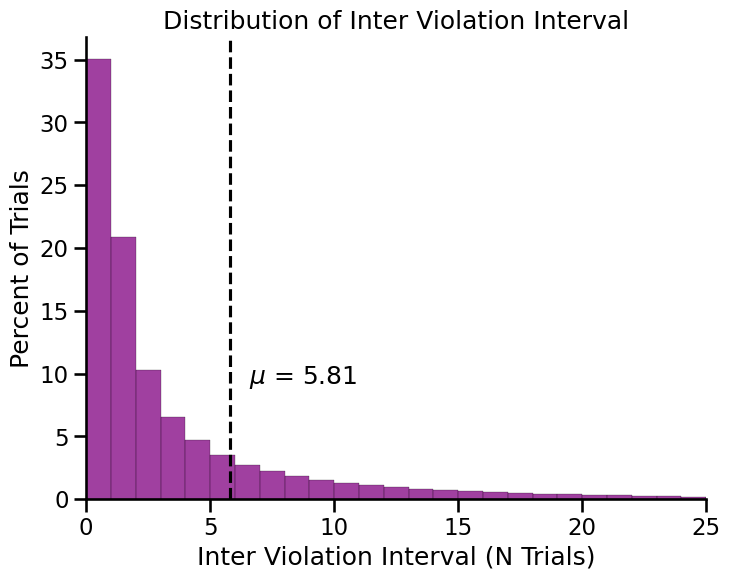

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=iti_df,
    x="violation_iti",
    stat="percent",
    color="purple",
    ax=ax,
    binwidth=1,
)

ax.set(
    xlim=(0, 25),
    xlabel="Inter Violation Interval (N Trials)",
    ylabel="Percent of Trials",
    title="Distribution of Inter Violation Interval",
)

# ax.axvline(iti_df.violation_iti.median(), color="grey", linestyle="--", label="Median")
ax.annotate(
    f"$\mu$ = {session_animal_avg_viol_iti:.2f}",
    xy=(0.35, 0.25),
    xycoords="axes fraction",
    ha="center",
)
ax.axvline(session_animal_avg_viol_iti, color="black", linestyle="--", label="Mean")

sns.despine()

### Save Out

In [15]:
iti_df.to_csv(
    "../data/processed/from_eda/03_viol_iti_df.csv", index=False
)  # in git ignore

violation_iti_summary_stats = (
    iti_df.groupby(["animal_id", "session"])
    .agg(
        viol_iti_mean=("violation_iti", "mean"),
        viol_iti_median=("violation_iti", "median"),
    )
    .reset_index()
    .groupby("animal_id")
    .agg({"viol_iti_mean": "mean", "viol_iti_median": "median"})
    .reset_index()
)

violation_iti_summary_stats.to_csv(
    "../data/processed/from_eda/03_viol_iti_summary_stats.csv", index=False
)
violation_iti_summary_stats.head()

,animal_id,viol_iti_mean,viol_iti_median
0,W051,6.750916,4.0
1,W060,7.114417,4.0
2,W065,3.266451,1.0
3,W066,3.242801,2.0
4,W068,5.636738,3.0


## Weight vs
TTT, trained hit, trained viol (make df), viol iti_mean and median

In [2]:
prev_viol_weights = pd.read_csv(
    "../data/processed/tau_sweeps/prev_violation_history_weights.csv"
).drop(columns=["index"])

session_avg_performance = pd.read_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
)

viol_iti_stats = pd.read_csv(
    "../data/processed/from_eda/03_viol_iti_summary_stats.csv"
).drop(columns=["viol_iti_median"])


weights_df = pd.merge(prev_viol_weights, session_avg_performance, on="animal_id")

weights_df = pd.merge(weights_df, viol_iti_stats, on="animal_id")

weights_df.head()

,animal_id,sigma,feature,weight,prev_violation_tau,trained_hit,trained_violation,viol_iti_mean
0,W051,16.00,prev_violation_exp,0.854792,2.0,0.796836,0.154370,6.750916
1,W060,16.00,prev_violation_exp,1.068390,2.0,0.825368,0.149891,7.114417
2,W065,0.13,prev_violation_exp,1.028606,2.0,0.775634,0.260626,3.266451
3,W066,16.00,prev_violation_exp,1.084039,25.0,0.788768,0.253332,3.242801
4,W068,16.00,prev_violation_exp,0.916764,40.0,0.778252,0.163857,5.636738


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

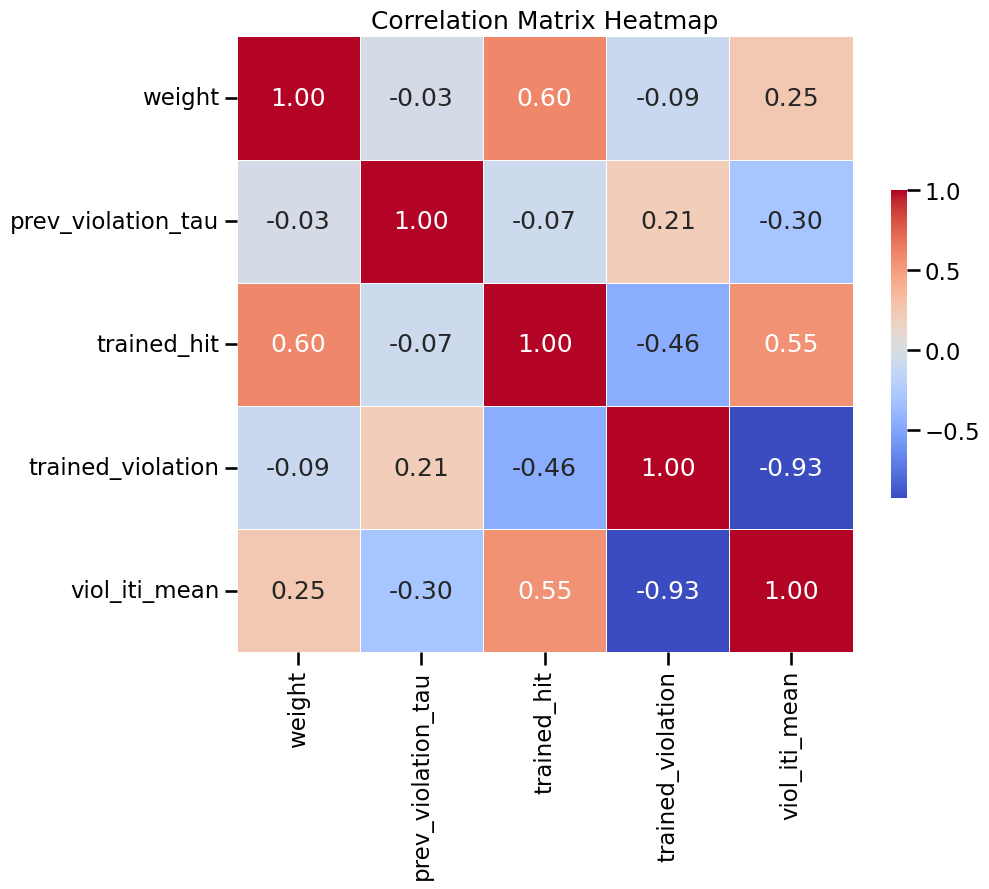

In [16]:
weight_corr = weights_df.drop(columns=["animal_id", "feature", "sigma"]).corr()
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    weight_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

# Add title
plt.title("Correlation Matrix Heatmap")

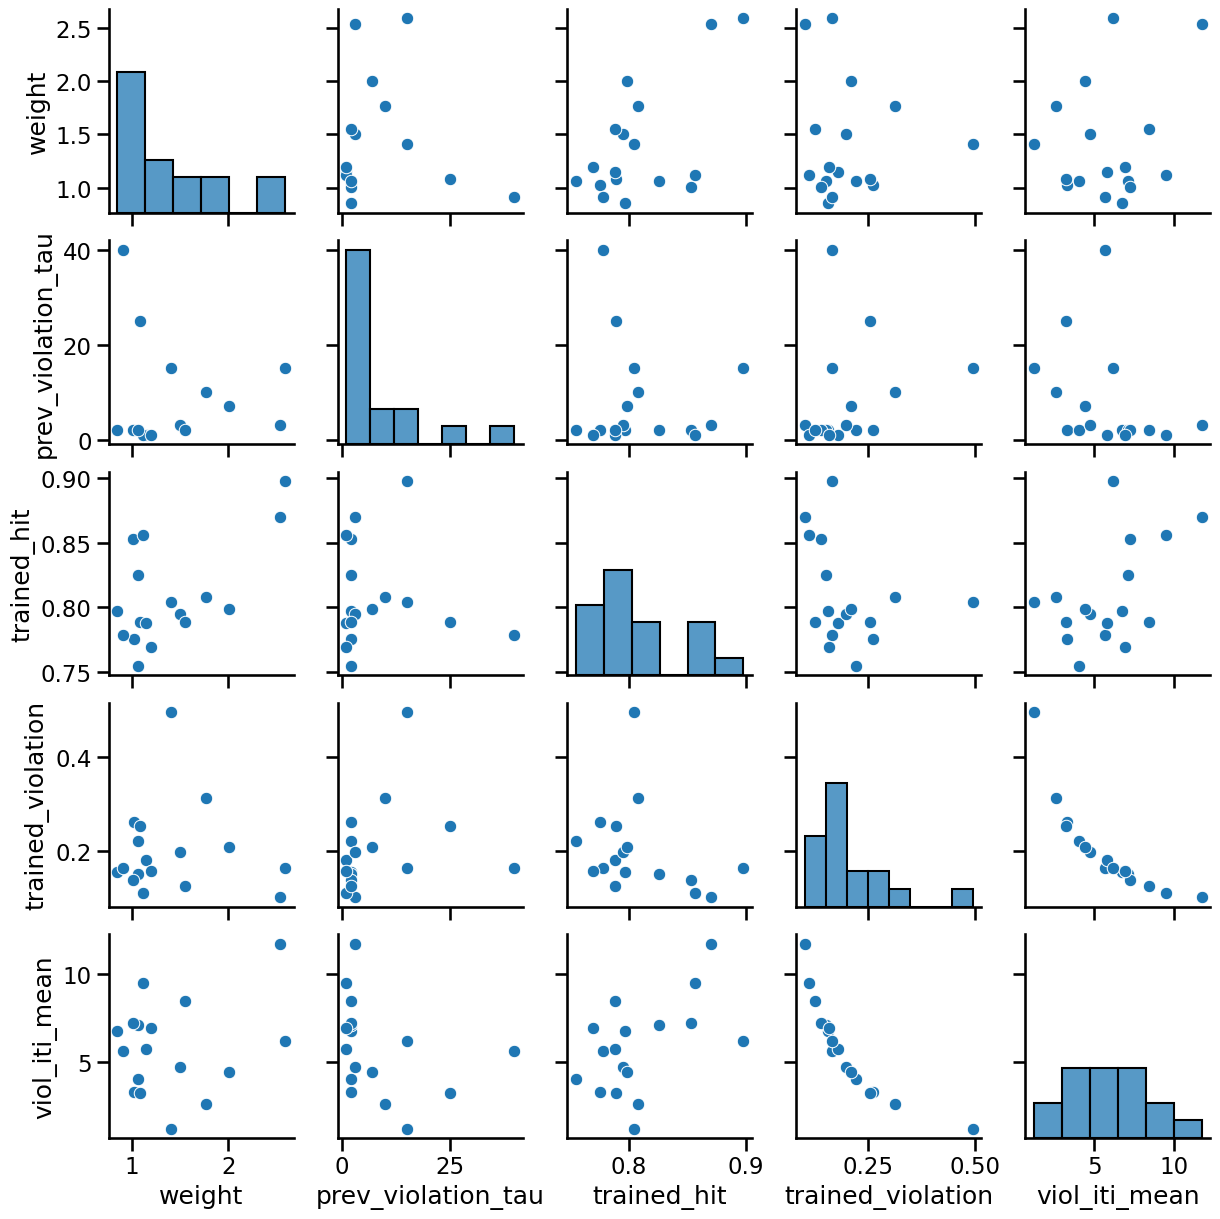

In [41]:
sns.pairplot(weights_df.drop(columns=["animal_id", "sigma"]))

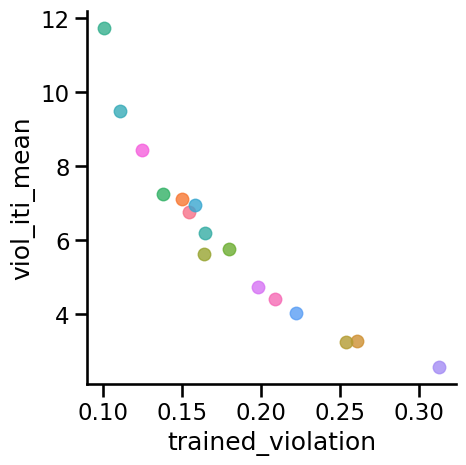

In [3]:
sns.lmplot(
    data=weights_df,
    x="trained_violation",
    y="viol_iti_mean",
    hue="animal_id",
    # s=100,
    legend=False,
)

Here we can see that higher violation rates (x-axis) have lower violation ITIs. This makes sense because there are more violations and they have reduced spread.

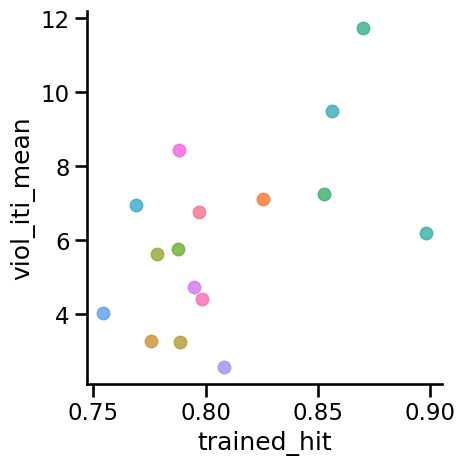

In [8]:
sns.lmplot(
    data=weights_df,
    x="trained_hit",
    y="viol_iti_mean",
    hue="animal_id",
    legend=False,
)

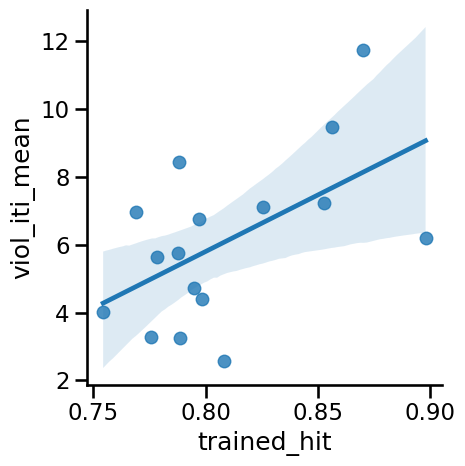

In [21]:
sns.lmplot(
    data=weights_df,
    x="trained_hit",
    y="viol_iti_mean",
    # hue="animal_id",
    legend=False,
)

Now we can see the opposite- higher hit rates appear correlated with larger violation itis meaning the animal is violating less. This is really interesting. Perhaps the rate of violations matters less than the actual grouping. Clearly these variables are highly correlated- a shorter mean iti means a lower violation rate. But this relationship is exponential. I want to keep this and mind and explore it further.

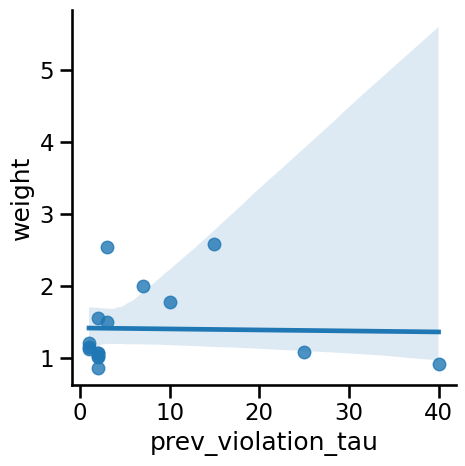

In [22]:
sns.lmplot(
    data=weights_df,
    x="prev_violation_tau",
    y="weight",
    # hue="animal_id",
    legend=False,
)

There doesn't appear to be much relationship between the magnitude of the weight and the size of the tau.

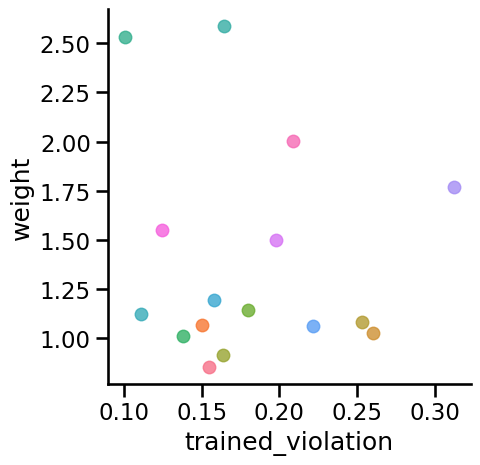

In [10]:
sns.lmplot(
    data=weights_df,
    x="trained_violation",
    y="weight",
    hue="animal_id",
    legend=False,
)

No clear trend here on trained violation rate and the weight.

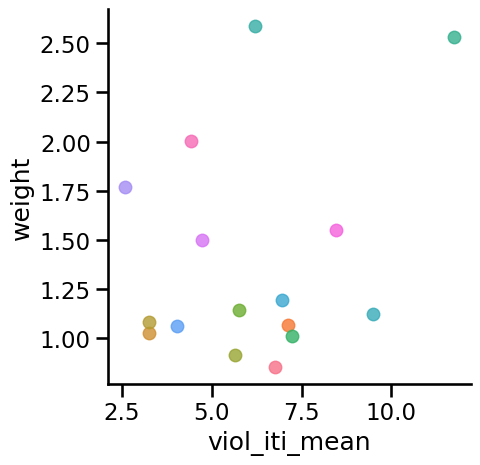

In [11]:
sns.lmplot(
    data=weights_df,
    x="viol_iti_mean",
    y="weight",
    hue="animal_id",
    legend=False,
)

There doesn't appear to be a clear correlation between the mean iti and the weight- it's hard to tell with so few samples.

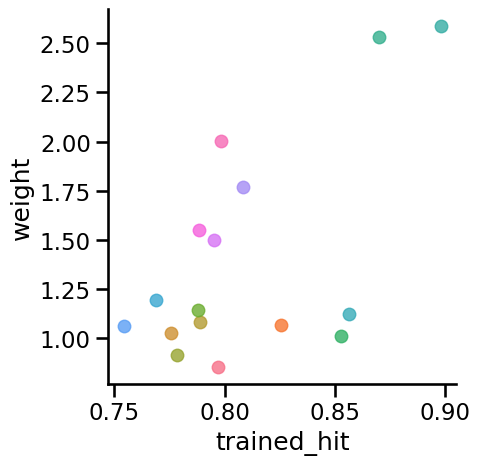

In [9]:
sns.lmplot(
    data=weights_df,
    x="trained_hit",
    y="weight",
    hue="animal_id",
    legend=False,
)

# plt.ylim(0, None)
# plt.xlim(0.5, 1)

(0.0, 2.8243057474365907)

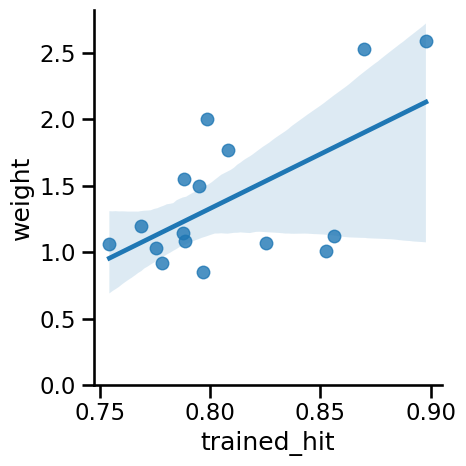

In [26]:
sns.lmplot(
    data=weights_df,
    x="trained_hit",
    y="weight",
    # hue="animal_id",
    legend=False,
)

plt.ylim(0, None)
# plt.xlim(0.5, 1)

This is really interesting- the largest prev violation weights belong to the animals with the best performance. I would have hypothesized this is the other way around. Perhaps, this is due to less noise in the data since they are doing the task well. Will need to think more on this.

## Tau vs 

TTT, trained hit rate, trained violation rate, prev violation weight, delta ll

- make df and pair plot of all vars

In [13]:
trained_thresholds = pd.read_csv(
    "../data/processed/dataset_thresholding/threshold_sessions.csv"
)

tau_df = pd.merge(trained_thresholds, weights_df, on="animal_id")

tau_df.head()

,animal_id,hit_threshold,violation_threshold,sigma,feature,weight,prev_violation_tau,trained_hit,trained_violation,viol_iti_mean
0,W051,325,NaN,16.00,prev_violation_exp,0.854792,2.0,0.796836,0.154370,6.750916
1,W060,247,NaN,16.00,prev_violation_exp,1.068390,2.0,0.825368,0.149891,7.114417
2,W065,100,397.0,0.13,prev_violation_exp,1.028606,2.0,0.775634,0.260626,3.266451
3,W066,285,NaN,16.00,prev_violation_exp,1.084039,25.0,0.788768,0.253332,3.242801
4,W068,422,NaN,16.00,prev_violation_exp,0.916764,40.0,0.778252,0.163857,5.636738


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

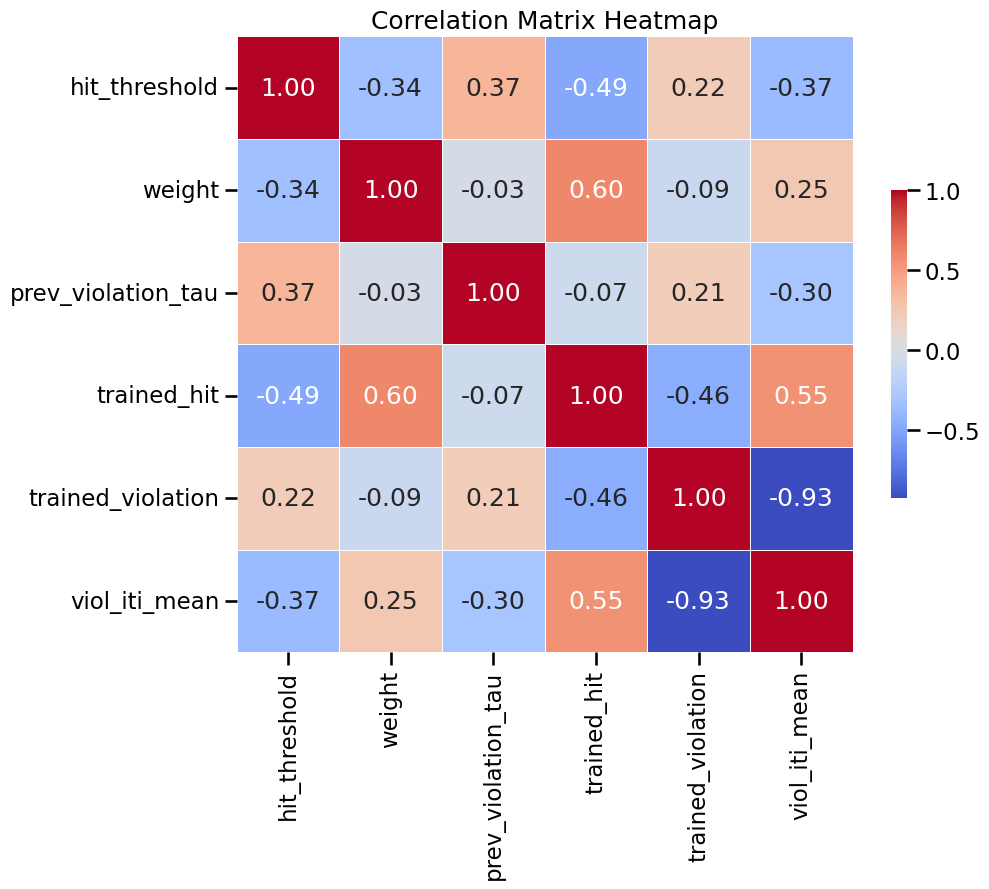

In [18]:
tau_corr = tau_df.drop(
    columns=["animal_id", "feature", "sigma", "violation_threshold"]
).corr()
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    tau_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

# Add title
plt.title("Correlation Matrix Heatmap")

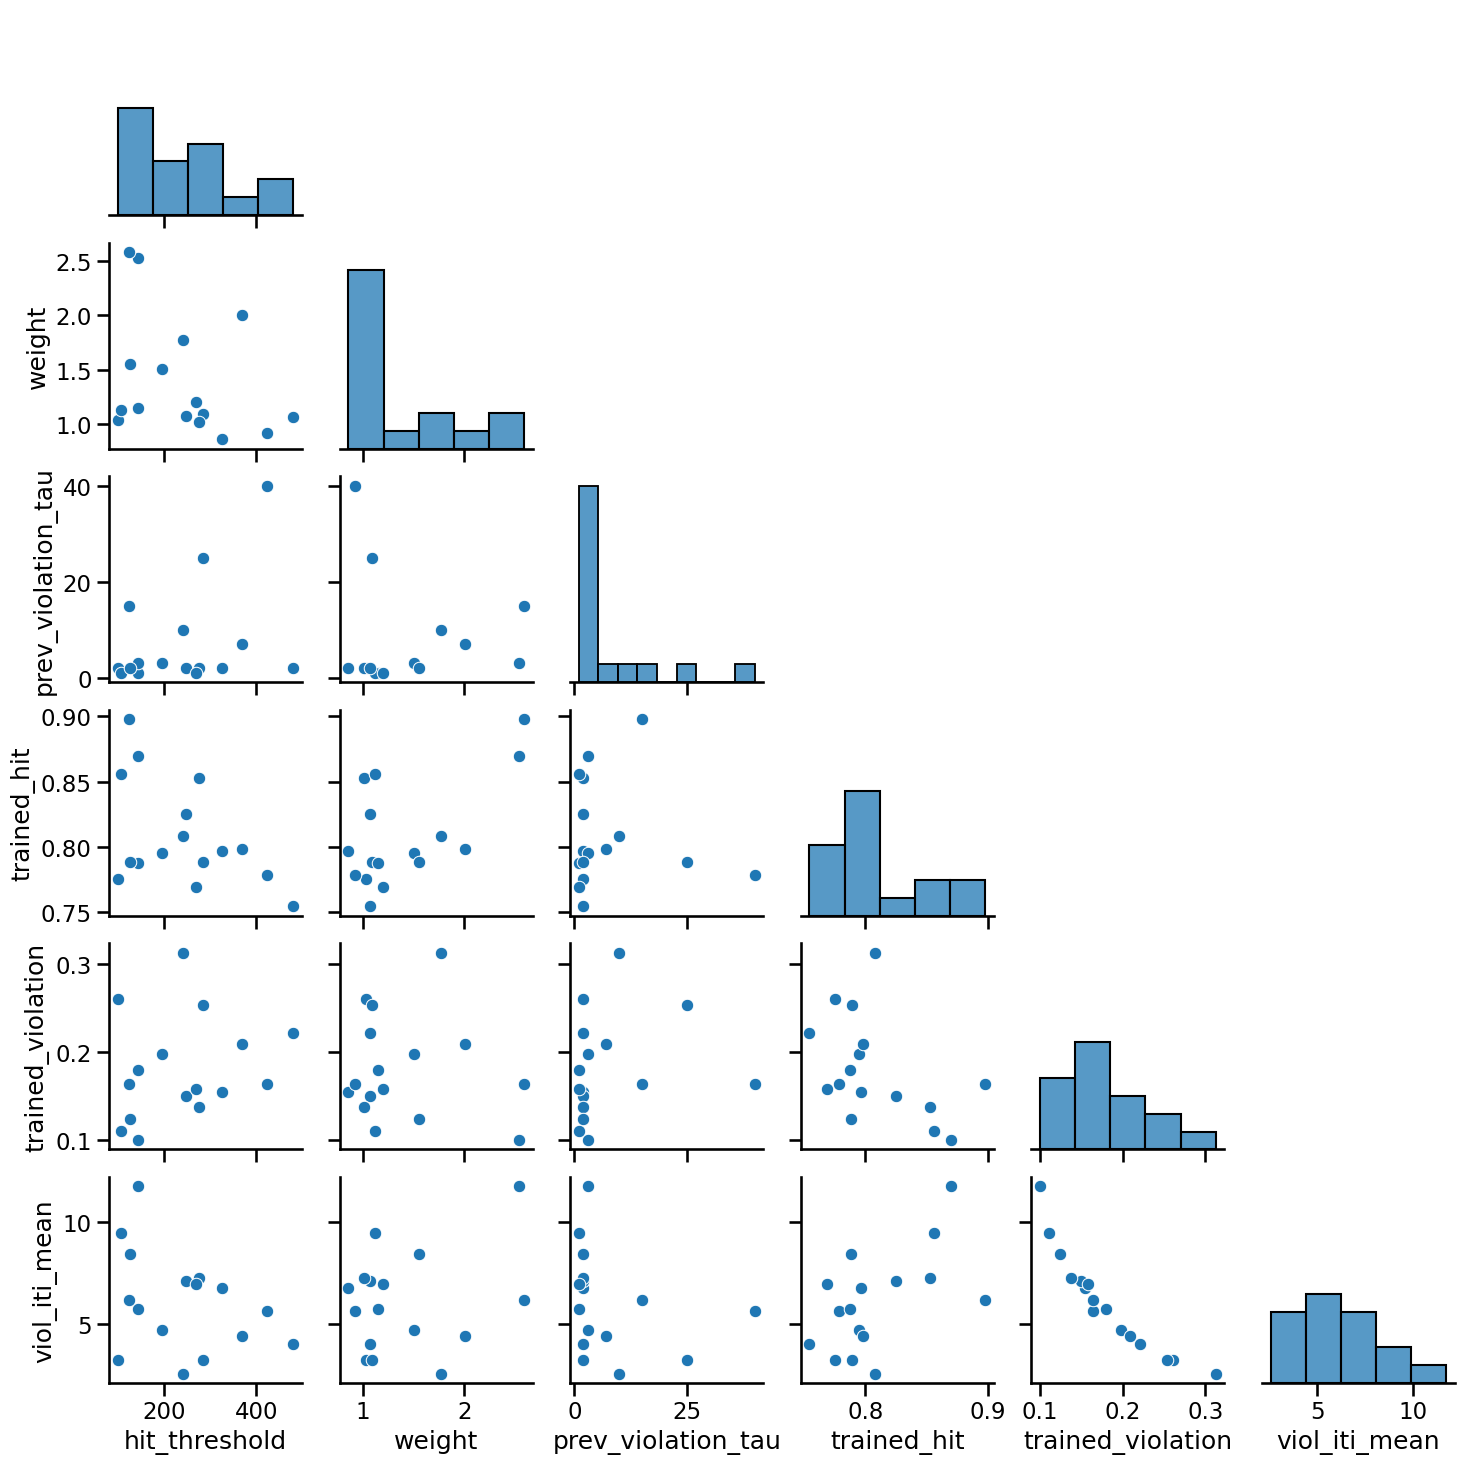

In [15]:
sns.pairplot(
    tau_df.drop(columns=["animal_id", "sigma", "violation_threshold"]), corner=True
)

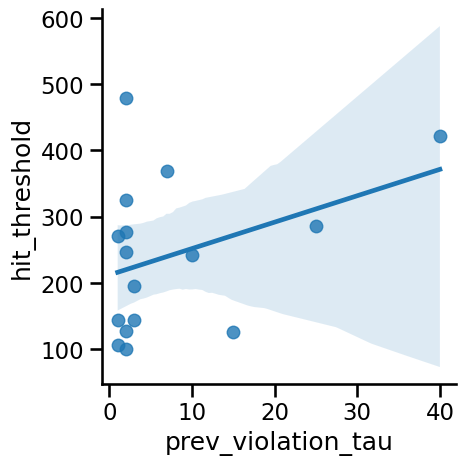

In [31]:
sns.lmplot(
    data=tau_df,
    x="prev_violation_tau",
    y="hit_threshold",
    # hue="animal_id",
    legend=False,
)

There is some correlation with prev violation tau and time to train. Let's see if we filter out the larger tau what it looks like.

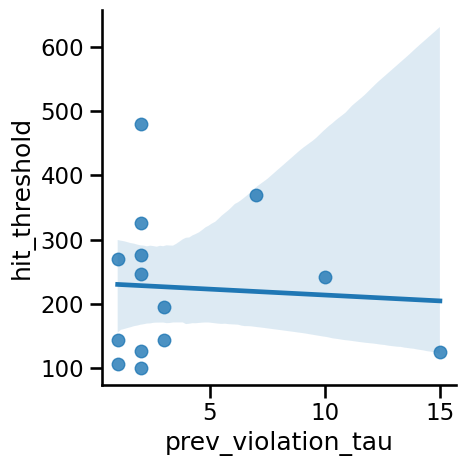

In [33]:
sns.lmplot(
    data=tau_df.query("prev_violation_tau < 16"),
    x="prev_violation_tau",
    y="hit_threshold",
    # hue="animal_id",
    legend=False,
)

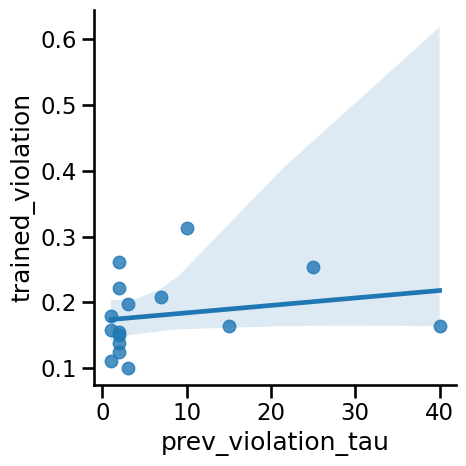

In [40]:
sns.lmplot(
    data=tau_df,
    x="prev_violation_tau",
    y="trained_violation",
    # hue="animal_id",
    legend=False,
    # color="k",
)

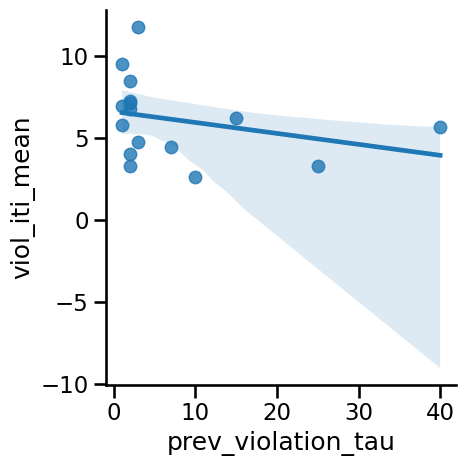

In [41]:
sns.lmplot(
    data=tau_df,
    x="prev_violation_tau",
    y="viol_iti_mean",
    # hue="animal_id",
    legend=False,
)

**Summary**: Most of the relationships here do not appear to be very strong. Part of this has to do with the distribution of taus being so wide and with a few animals that are outliers. There does appear to be a relationship with larger taus and lower means.

The most interesting of them all is the relationship between trained hit rate, viol_iti_mean and prev violation weights.